<a href="https://colab.research.google.com/github/hypro2/multimodal-colab/blob/main/e5_mistral_embedding_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U transformers peft accelerate optimum
!pip install --quiet bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.5/402.5 kB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel


def last_token_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]


def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'


In [8]:
# Each query must come with a one-sentence instruction that describes the task
task = 'Given a web search query, retrieve relevant passages that answer the query'
queries = [
    get_detailed_instruct(task, 'how much protein should a female eat'),
    get_detailed_instruct(task, 'summit define')
]
# No need to add instruction for retrieval documents
documents = [
    "As a general guideline, the CDC's average requirement of protein for women ages 19 to 70 is 46 grams per day. But, as you can see from this chart, you'll need to increase that if you're expecting or training for a marathon. Check out the chart below to see how much protein you should be eating each day.",
    "Definition of summit for English Language Learners. : 1  the highest point of a mountain : the top of a mountain. : 2  the highest level. : 3  a meeting or series of meetings between the leaders of two or more governments."
]

input_texts = queries + documents
input_texts

['Instruct: Given a web search query, retrieve relevant passages that answer the query\nQuery: how much protein should a female eat',
 'Instruct: Given a web search query, retrieve relevant passages that answer the query\nQuery: summit define',
 "As a general guideline, the CDC's average requirement of protein for women ages 19 to 70 is 46 grams per day. But, as you can see from this chart, you'll need to increase that if you're expecting or training for a marathon. Check out the chart below to see how much protein you should be eating each day.",
 'Definition of summit for English Language Learners. : 1  the highest point of a mountain : the top of a mountain. : 2  the highest level. : 3  a meeting or series of meetings between the leaders of two or more governments.']

In [2]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-mistral-7b-instruct')
model = AutoModel.from_pretrained('intfloat/e5-mistral-7b-instruct', load_in_4bit=True )

max_length = 4096

# Tokenize the input texts
batch_dict = tokenizer(input_texts, max_length=max_length - 1, return_attention_mask=False, padding=False, truncation=True)

# append eos_token_id to every input_ids
batch_dict['input_ids'] = [input_ids + [tokenizer.eos_token_id] for input_ids in batch_dict['input_ids']]
batch_dict = tokenizer.pad(batch_dict, padding=True, return_attention_mask=True, return_tensors='pt')

outputs = model(**batch_dict)
embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/956 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.28G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')


In [3]:
embeddings

tensor([[ 0.0195,  0.0023, -0.0094,  ...,  0.0269, -0.0207,  0.0070],
        [-0.0003,  0.0025,  0.0144,  ...,  0.0321, -0.0041,  0.0025],
        [ 0.0187,  0.0040, -0.0098,  ...,  0.0115, -0.0099,  0.0056],
        [ 0.0010, -0.0114, -0.0087,  ...,  0.0167,  0.0034,  0.0138]],
       dtype=torch.float16, grad_fn=<DivBackward0>)

In [4]:
len(embeddings)

4

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
distances = cosine_similarity(embeddings.detach().numpy())
distances

array([[1.        , 0.4686674 , 0.83873295, 0.46731568],
       [0.4686674 , 1.        , 0.46111792, 0.81595298],
       [0.83873295, 0.46111792, 1.        , 0.48365757],
       [0.46731568, 0.81595298, 0.48365757, 1.        ]])

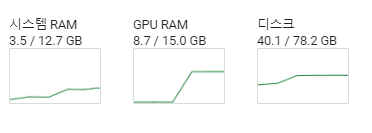